# Sex prediction

In [22]:
%load_ext autoreload
%autoreload 2

In [77]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation


In [13]:
colors = sn.color_palette("Set2") 

In [6]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')

In [7]:
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [8]:
tsetse_data_copy = tsetse_data.copy()

In [9]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data[dList]
tsetse_data.drop(dList, axis=1,inplace=True)

wnLabels= tsetse_data.columns.values.tolist() #wavenumbers labels
waveNums = [int(x) for x in wnLabels] #wavenumbers numbers (for plotting)

## Clustering

In [10]:
tsetse_females = tsetse_data.loc[(descriptorsDF['Sex'] == 'f')]
tsetse_males = tsetse_data[(descriptorsDF['Sex'] == 'm')]
tsetse_head = tsetse_data[(descriptorsDF['Tissue'] == 'Head')]
tsetse_thorax = tsetse_data[(descriptorsDF['Tissue'] == 'Thorax')]
tsetse_abdomen = tsetse_data[(descriptorsDF['Tissue'] == 'Abdomen')]

In [11]:
pca = PCA(n_components=5)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(tsetse_data)
X_pca_all = pca.fit_transform(X_scaled)

X_scaled_head = scaler_pca.fit_transform(tsetse_head)
X_pca_head = pca.fit_transform(X_scaled_head)

X_scaled_thorax = scaler_pca.fit_transform(tsetse_thorax)
X_pca_thorax = pca.fit_transform(X_scaled_thorax)

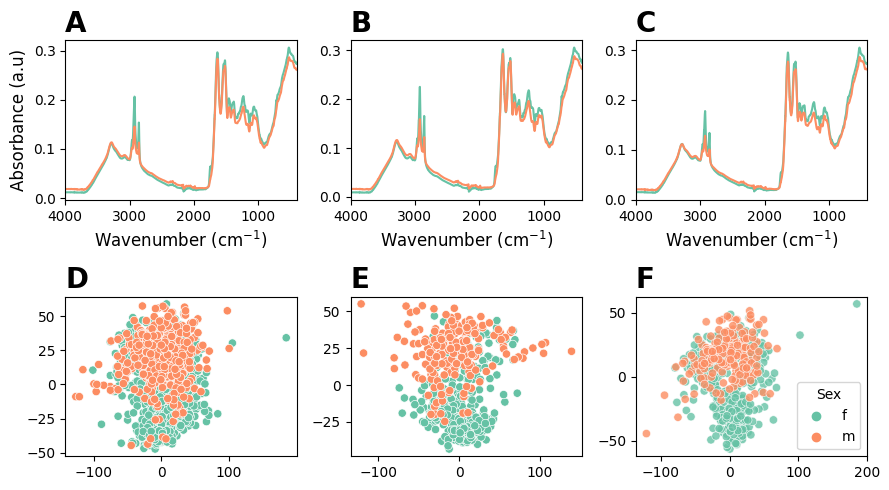

In [17]:
fig, ((ax, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(9,5))

sn.set_palette("Set2")
sn.scatterplot(x=X_pca_all[:,0], y=X_pca_all[:,1], hue=descriptorsDF['Sex'], ax=ax4, legend=False)

sn.scatterplot(x=X_pca_head[:,0], y=X_pca_head[:,1], hue=descriptorsDF[descriptorsDF['Tissue'] == 'Head']['Sex'], ax=ax5, legend=False)

sn.scatterplot(x=X_pca_thorax[:,0], y=X_pca_thorax[:,1],ax=ax6, hue=descriptorsDF[descriptorsDF['Tissue'] == 'Thorax']['Sex'], alpha=0.8)



y_labels = descriptorsDF['Sex']

for i, c in zip(np.unique(y_labels), colors):
    sn.lineplot(x=waveNums, y=np.mean(tsetse_data[y_labels == i], axis=0), label=i, color=c,ax=ax, legend=False)

ax.set_xlim(4000,401)
ax.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax.set_ylabel("Absorbance (a.u)",fontsize=12)

y_labels = descriptorsDF[descriptorsDF['Tissue'] == 'Head']['Sex']

for i, c in zip(np.unique(y_labels), colors):
    sn.lineplot(x=waveNums, y=np.mean(tsetse_head[y_labels == i], axis=0), label=i, color=c,ax=ax2, legend=False)

ax2.set_xlim(4000,401)
ax2.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)



y_labels = descriptorsDF[descriptorsDF['Tissue'] == 'Thorax']['Sex']
for i, c in zip(np.unique(y_labels), colors):
    sn.lineplot(x=waveNums, y=np.mean(tsetse_thorax[y_labels == i], axis=0), label=i, color=c,ax=ax3, legend=False)

ax3.set_xlim(4000,401)
ax3.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)



labeles = ["A", "B", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='left', fontsize=20, fontweight='bold')


ax.set_ylabel("Absorbance (a.u)")

plt.tight_layout()

plt.savefig("../results/plots/PCA_sex.png", dpi=900)

## Sex prediction

In [18]:
tsetse_thorax = tsetse_data_copy.loc[descriptorsDF['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_copy.loc[descriptorsDF['Tissue'] == 'Head']

In [19]:
tsetse_head.groupby("Sex")["ID"].count()

Sex
f    345
m    187
Name: ID, dtype: int64

In [24]:
X_thorax = tsetse_thorax.loc[:,"4000":"402"]
y_thorax = tsetse_thorax.loc[:,"Sex"]

X_head = tsetse_head.loc[:,"4000":"402"]
y_head = tsetse_head.loc[:,"Sex"]

In [81]:
X_thorax.to_csv("../data/processed/X_thorax.csv", index=False)
y_thorax.to_csv("../data/processed/y_thorax_sex.csv", index=False)

In [25]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [26]:
thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [27]:
data_plot_thorax = dataplotmelt(thorax_acc_baseline)
data_plot_head = dataplotmelt(head_acc_baseline)

In [38]:
# test head

y_head_pred, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train)
y_thorax_pred, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train)

In [36]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9719626168224299
Accuracy on test set: 0.9166666666666666


In [45]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
f,0.962025,1.000000,0.980645,76.000000
m,1.000000,0.903226,0.949153,31.000000
accuracy,0.971963,0.971963,0.971963,0.971963
macro avg,0.981013,0.951613,0.964899,107.000000
weighted avg,0.973027,0.971963,0.971521,107.000000


In [51]:
report_head.to_excel("../results/tables/accuracy_sex_head.xlsx")

In [46]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
f,0.957143,0.917808,0.937063,73.000000
m,0.842105,0.914286,0.876712,35.000000
accuracy,0.916667,0.916667,0.916667,0.916667
macro avg,0.899624,0.916047,0.906888,108.000000
weighted avg,0.919862,0.916667,0.917505,108.000000


In [52]:
report_thorax.to_excel("../results/tables/accuracy_sex_thorax.xlsx")

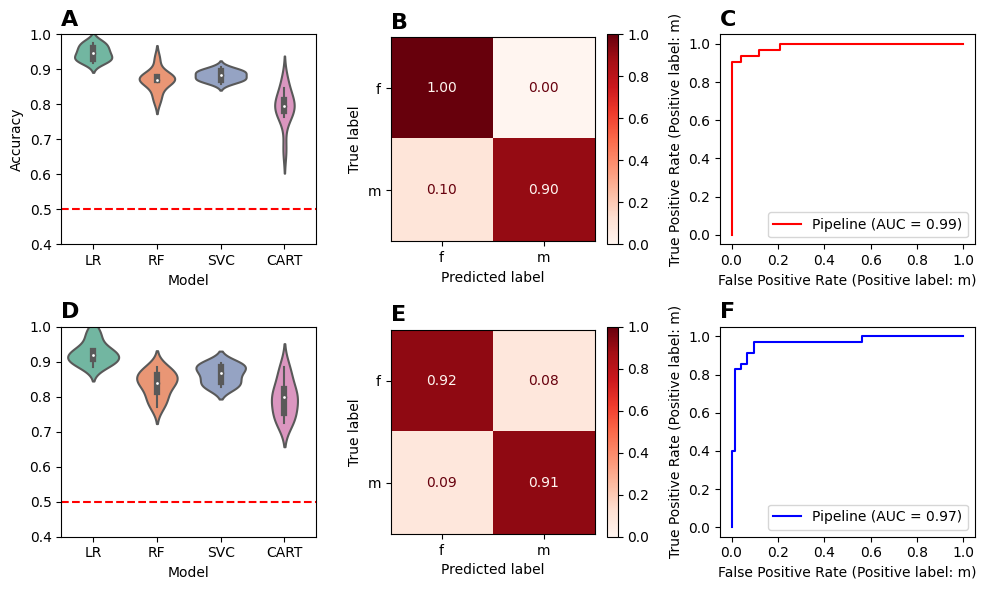

In [76]:
fig, ((ax,ax2, ax5),(ax3,ax4, ax6)) = plt.subplots(2,3,figsize=(10,6))
sn.violinplot(data=data_plot_head, x='param_clf',y='value',ax=ax)
sn.violinplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy')
ax.set_ylim(0.4,1)
ax3.set_ylim(0.4,1)
ax.axhline(0.5, color='r',ls="--")
ax3.axhline(0.5, color='r',ls="--")
ax3.set_ylabel('')
ax3.set_xlabel("Model")


disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


RocCurveDisplay.from_estimator(pipe_head, X=X_hd_test, y=y_hd_test, ax=ax5, color='r')

RocCurveDisplay.from_estimator(pipe_thorax, X=X_th_test, y=y_th_test, ax=ax6, color='b')

sizeletters = 16
ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold', size=sizeletters)
ax3.set_title("D", loc='left', weight='bold', size=sizeletters)
ax4.set_title("E", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("F", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

plt.savefig("../results/plots/sex_prediction.png", dpi=900)


## Nested cross validation

In [82]:
X_thorax_nested = pd.read_csv("../data/processed/X_thorax.csv")
y_thorax_nested = pd.read_csv("../data/processed/y_thorax_sex.csv")

In [93]:
cm_nested_th, y_pred_nested_th, y_test_nested_th =  nested_crossvalidation(X_thorax, y_thorax)

>acc=0.926, est=0.983, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
>acc=0.907, est=0.980, cfg={'model__C': 10, 'model__solver': 'newton-cg'}
>acc=1.000, est=0.976, cfg={'model__C': 10, 'model__solver': 'liblinear'}
>acc=0.981, est=0.979, cfg={'model__C': 100, 'model__solver': 'liblinear'}
>acc=0.963, est=0.978, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
>acc=0.944, est=0.987, cfg={'model__C': 100, 'model__solver': 'liblinear'}
>acc=0.944, est=0.977, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
>acc=1.000, est=0.982, cfg={'model__C': 10, 'model__solver': 'newton-cg'}
>acc=0.944, est=0.980, cfg={'model__C': 100, 'model__solver': 'liblinear'}
>acc=0.943, est=0.985, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Mean accuracy: 0.96 (0.03)
